***

*Course:* [Math 535](https://people.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Chapter:* 5-Random walks on graphs and Markov chains  
*Author:* [Sebastien Roch](https://people.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
*Updated:* Jan 20, 2024   
*Copyright:* &copy; 2024 Sebastien Roch

***

In [ ]:
# You will need the files:
#     * mmids.py
#     * mathworld-adjacency.csv
#     * mathworld-titles.csv
# from https://github.com/MMiDS-textbook/MMiDS-textbook.github.io/tree/main/utils
#
# IF RUNNING ON GOOGLE COLAB (RECOMMENDED):
# "Upload to session storage" from the Files tab on the left
# Alternative instructions: https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
# PYTHON 3
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import tensorflow as tf
from tensorflow import keras
import mmids
seed = 535
rng = np.random.default_rng(seed)

## Motivating example: discovering relevant mathematical topics

A common task in network analysis is to identify "central" vertices in a graph. Centrality is a vague concept. It can be defined in many different ways depending on the context and the type of network. Quoting from [Wikipedia](https://en.wikipedia.org/wiki/Centrality):

> In graph theory and network analysis, indicators of centrality assign numbers or rankings to nodes within a graph corresponding to their network position. Applications include identifying the most influential person(s) in a social network, key infrastructure nodes in the Internet or urban networks, super-spreaders of disease, and brain networks. [...] Centrality indices are answers to the question "What characterizes an important vertex?" The answer is given in terms of a real-valued function on the vertices of a graph, where the values produced are expected to provide a ranking which identifies the most important nodes. The word "importance" has a wide number of meanings, leading to many different definitions of centrality. 

In an undirected graph, a natural approach is to look at the degree of a vertex as a measure of its importance (also referred to as degree centrality). But it is hardly the only one. One could for instance look at the average distance to all other nodes (its reciprocal is the [closeness centrality](https://en.wikipedia.org/wiki/Closeness_centrality)) or at the number of shortest paths between pairs of vertices going through the vertex (known as [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality)). 

What if the graph is directed? Things are somewhat more complicated there. For instance, there is now the in-degree as well as the out-degree. 

Let us look at a particular example of practical importance, the World Wide Web (from now on, the Web). In this case, the vertices are webpages and a directed edge from $u$ to $v$ indicates a hyperlink from page $u$ to page $v$. The Web is much too large to analyze here. Instead, we will consider a tiny (but still interesting!) subset of it, the pages of [Wolfram's MathWorld](https://mathworld.wolfram.com), a wonderful mathematics resource. 

Each page of MathWorld concerns a particular mathematical concept, e.g., [scale-free network](https://mathworld.wolfram.com/Scale-FreeNetwork.html). A definition and notable properties are described. Importantly for us, in a section entitled "SEE ALSO", other related mathematical concepts are listed with a link to their MathWorld page. In the case of scale-free networks, the [small world network](https://mathworld.wolfram.com/SmallWorldNetwork.html) topic is referenced, among others.

The resulting directed graph is available through the [NetSet](https://netset.telecom-paris.fr/index.html) datasets and can be downloaded [here](https://netset.telecom-paris.fr/pages/mathworld.html). We load it now. For convenience, we have reformatted it into the files `mathworld-adjacency.csv` and `mathworld-titles.csv`, which are available on the [GitHub of the book](https://github.com/MMiDS-textbook/MMiDS-textbook.github.io/tree/main/utils/datasets).

In [ ]:
df_edges = pd.read_csv('mathworld-adjacency.csv')
df_edges.head()

It consists in a list of directed edges. For example, the first one is an edge from vertex `0` to vertex `2`. The second one is from `1` to `47` and so on. 

There is a total of $49069$ edges.

In [ ]:
df_edges.shape[0]

The second file contains the titles of the pages.

In [ ]:
df_titles = pd.read_csv('mathworld-titles.csv')
df_titles.head()

So the first edge above is from `Alexander's Horned Sphere` to `Antoine's Horned Sphere`. That is, the [latter](https://mathworld.wolfram.com/AntoinesHornedSphere.html) is listed in the "SEE ALSO" section of the [former](https://mathworld.wolfram.com/AlexandersHornedSphere.html). 

There are $12362$ topics.

In [ ]:
df_titles.shape[0]

We construct the graph by adding the edges one by one. We first convert `df_edges` into a Numpy array.

In [ ]:
edgelist = df_edges[['from','to']].to_numpy()
print(edgelist)

In [ ]:
n = 12362
G = nx.empty_graph(n, create_using=nx.DiGraph)
for i in range(edgelist.shape[0]):
    G.add_edge(edgelist[i,0], edgelist[i,1])

In [ ]:
G.in_degree(0)

while that of `Antoine's Horned Sphere` is:

In [ ]:
G.in_degree(2)

suggesting that the former is more central than the latter, at least in the sense that it is referenced more often.

But is that the right measure? Consider the following: `Antoine's Horned Sphere` receives only one reference, but it is from a seemingly relatively important vertex, `Alexander's Horned Sphere`. How can one take this into account in quantifying its importance in the network?

We will come back to this question later in this chapter. To hint at things to come, it will turn out that "exploring the graph at random" provides a powerful perspective on centrality.  

$\newcommand{\P}{\mathbb{P}}$ $\newcommand{\E}{\mathbb{E}}$ $\newcommand{\S}{\mathcal{S}}$ $\newcommand{\indep}{\perp\!\!\!\perp}$    $\newcommand{\bmu}{\boldsymbol{\mu}}$ $\newcommand{\bpi}{\boldsymbol{\pi}}$

## Elements of finite Markov chains

**EXAMPLE:** **(Random Walk on the Petersen Graph)** Let $G = (V,E)$ be the Petersen graph.

In [ ]:
G_petersen = nx.petersen_graph()

In [ ]:
nx.draw_networkx(G_petersen, pos=nx.circular_layout(G_petersen), labels={i: i+1 for i in range(10)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

Each vertex $i$ has degree $3$, that is, it has three neighbors which we denote $v_{i,1}, v_{i,2}, v_{i,3}$ in some arbitrary order. For instance, denoting the vertices by $1,\ldots, 10$ as above, vertex $9$ has neighbors $v_{9,1} = 4, v_{9,2} = 6, v_{9,3} = 7$.

We consider the following random walk on $G$. We start at $X_0 = 1$. Then, for each $t\geq 0$, we let $X_{t+1}$ be a uniformly chosen neighbor of $X_t$, independently of the previous history. That is, we jump at random from neighbor to neighbor. Formally, fix $X_0 = 1$ and let $(Z_t)_{t \geq 0}$ be an i.i.d. sequence of random variables taking values in $\{1,2,3\}$ satisfying

$$
\mathbb{P}[Z_t = 1] = \mathbb{P}[Z_t = 2] = \mathbb{P}[Z_t = 3] = 1/3.
$$

Then define, for all $t \geq 0$,
$
X_{t+1}
= f(X_t, Z_t)
= v_{i,Z_t}
$
if $X_t = v_i$.

By an argument similar to the previous example, $(X_t)_{t \geq 0}$ is a Markov chain.
Also as in the previous example, one can pick $X_0$ according to an initial distribution, independently from the sequence $(Z_t)_{t \geq 0}$.

$\lhd$

**EXAMPLE:** **(Random Walk on the Petersen Graph, continued)** Consider again the random walk on the Petersen graph $G = (V,E)$. We number the vertices $1, 2,\ldots, 10$. To compute the transition matrix, we list for each vertex its neighbors and put the value $1/3$ in the corresponding columns. For instance, vertex $1$ has neighbors $2$, $5$ and $6$, so row $1$ has $1/3$ in columns $2$, $5$, and $6$. And so on.

In [ ]:
nx.draw_networkx(G_petersen, pos=nx.circular_layout(G_petersen), labels={i: i+1 for i in range(10)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

We get:

$$
P = \begin{pmatrix}
0 & 1/3 & 0 & 0 & 1/3 & 1/3 & 0 & 0 & 0 & 0\\
1/3 & 0 & 1/3 & 0 & 0 & 0 & 1/3 & 0 & 0 & 0\\
0 & 1/3 & 0 & 1/3 & 0 & 0 & 0 & 1/3 & 0 & 0\\
0 & 0 & 1/3 & 0 & 1/3 & 0 & 0 & 0 & 1/3 & 0\\
1/3 & 0 & 0 & 1/3 & 0 & 0 & 0 & 0 & 0 & 1/3\\
1/3 & 0 & 0 & 0 & 0 & 0 & 0 & 1/3 & 1/3 & 0\\
0 & 1/3 & 0 & 0 & 0 & 0 & 0 & 0 & 1/3 & 1/3\\
0 & 0 & 1/3 & 0 & 0 & 1/3 & 0 & 0 & 0 & 1/3\\
0 & 0 & 0 & 1/3 & 0 & 1/3 & 1/3 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1/3 & 0 & 1/3 & 1/3 & 0 & 0
\end{pmatrix}
$$

We have already encountered a matrix that encodes the neighbors of each vertex, the adjacency matrix. Here we can recover the transition matrix by multiplying the adjacency matrix by $1/3$.

In [ ]:
A_petersen = nx.adjacency_matrix(G_petersen).toarray()
P_petersen = (1/3) * A_petersen
print(P_petersen)

$\lhd$

**EXAMPLE:** **(Robot Vacuum, continued)** Returning to our *Robot Vacuum Example*, the transition graph of the chain can be obtained by thinking of $P$ as the weighted adjacency matrix of the transition graph. 

In [ ]:
P_robot = np.array([
[0, 0.8, 0, 0.2, 0, 0, 0, 0, 0],
[0.3, 0, 0.2, 0, 0, 0.5, 0, 0, 0],
[0, 0.6, 0, 0, 0, 0.4, 0, 0, 0],
[0.1, 0.1, 0, 0, 0.8, 0, 0, 0, 0],
[0, 0, 0, 0.25, 0, 0, 0.75, 0, 0],
[0, 0.15, 0.15, 0, 0, 0, 0, 0.35, 0.35],
[0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0.3, 0.4, 0.2, 0, 0.1],
[0, 0, 0, 0, 0, 1, 0, 0, 0]
]
)
print(P_robot)

We define a graph from its adjancency matrix. See [`networkx.from_numpy_array()`](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html).

In [ ]:
G_robot = nx.from_numpy_array(P_robot, create_using=nx.DiGraph)

Drawing edge weights on a directed graph in a readable fashion is not straighforward. We will not do this here. 

In [ ]:
n_robot = P_robot.shape[0]
nx.draw_networkx(G_robot, pos=nx.circular_layout(G_robot), 
                 labels={i: i+1 for i in range(n_robot)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white', 
                 connectionstyle='arc3, rad = 0.2')

$\lhd$

**NUMERICAL CORNER:** Once we have specified a transition matrix (and an initial distribution), we can simulate the corresponding Markov chain. This is useful to compute (approximately) probabilities of complex events through the law of large numbers. Here is some code to generate one sample path up to some given time $T$. We assume that the state space is $[n]$. We use [`rng.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html) to generate each transition.

In [ ]:
from numpy.random import default_rng
rng = default_rng(535)

In [ ]:
def SamplePath(mu, P, T):
    n = mu.shape[0] # size of state space
    X = np.zeros(T+1) # initialization of sampe path
    for i in range(T+1):
        if i == 0: # initial distribution
            X[i] = rng.choice(a=np.arange(start=1,stop=n+1),p=mu)
        else: # next state is chosen from current state row
            X[i] = rng.choice(a=np.arange(start=1,stop=n+1),p=P[int(X[i-1]-1),:])
    return X

Let's try with our *Robot Vacuum*. We take the initial distribution to be the uniform distribution.

In [ ]:
mu = np.ones(n_robot) / n_robot
SamplePath(mu, P_robot, 10)

For example, we can use a simulation to approximate the expected number of times that room $9$ is visited up to time $10$. To do this, we run the simulation a large number of times (say $1000$) and count the average number of visits to $9$.

In [ ]:
z = 9 # state of interest
N_samples = 1000 # number of repetitions
visits_to_z = np.zeros(N_samples) # initialization of number of visits

for i in range(N_samples):
    visits_to_z[i] = np.count_nonzero(SamplePath(mu, P_robot, 10) == z)

print(np.mean(visits_to_z))

$\lhd$

$\newcommand{\P}{\mathbb{P}}$ $\newcommand{\E}{\mathbb{E}}$ $\newcommand{\S}{\mathcal{S}}$ $\newcommand{\indep}{\perp\!\!\!\perp}$ $\newcommand{\bmu}{\boldsymbol{\mu}}$ $\newcommand{\bpi}{\boldsymbol{\pi}}$

## Limit behavior

**EXAMPLE:** **(Robot Vacuum, continued)** Going back to the *Robot Vacuum Example*, recall the transition graph above.

In [ ]:
P_robot = np.array([
[0, 0.8, 0, 0.2, 0, 0, 0, 0, 0],
[0.3, 0, 0.2, 0, 0, 0.5, 0, 0, 0],
[0, 0.6, 0, 0, 0, 0.4, 0, 0, 0],
[0.1, 0.1, 0, 0, 0.8, 0, 0, 0, 0],
[0, 0, 0, 0.25, 0, 0, 0.75, 0, 0],
[0, 0.15, 0.15, 0, 0, 0, 0, 0.35, 0.35],
[0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0.3, 0.4, 0.2, 0, 0.1],
[0, 0, 0, 0, 0, 1, 0, 0, 0]
]
)
G_robot = nx.from_numpy_array(P_robot, create_using=nx.DiGraph)
n_robot = P_robot.shape[0]

In [ ]:
nx.draw_networkx(G_robot, pos=nx.circular_layout(G_robot), 
                 labels={i: i+1 for i in range(n_robot)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white', 
                 connectionstyle='arc3, rad = 0.2')

While there is no direct edge from $4$ to $3$, we do have $4 \to 3$ through the path $(4,2), (2,3)$. Do we have $3 \to 4$?

$\lhd$

**EXAMPLE:** **(Two Sinks)** Consider the following random walk on a digraph.

In [ ]:
G_sinks = nx.DiGraph()

for i in range(5):
    G_sinks.add_node(i)

G_sinks.add_edge(0, 0, weight=1/3)
G_sinks.add_edge(0, 1, weight=1/3)
G_sinks.add_edge(1, 1, weight=1/3)
G_sinks.add_edge(1, 2, weight=1/3)
G_sinks.add_edge(2, 2, weight=1)
G_sinks.add_edge(3, 3, weight=1)
G_sinks.add_edge(0, 4, weight=1/3)
G_sinks.add_edge(1, 4, weight=1/3)
G_sinks.add_edge(4, 3, weight=1)

In [ ]:
nx.draw_networkx(G_sinks, pos=nx.circular_layout(G_sinks), 
                 labels={i: i+1 for i in range(5)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

Here we have $1 \to 4$ (Why?). The *Communication Lemma* implies that, when started at $1$, $(X_t)_{t \geq 0}$ visits $4$ with positive probability. But that probability is not one. Indeed we also have $1 \to 3$ (Why?), so there is a positive probability of visiting $3$ as well. But if we do so before visiting $4$, we stay at $3$ forever hence cannot subsequently reach $4$.

In fact, intuitively, if we run this chain long enough we will either get stuck at $3$ or get stuck at $4$. These give rise to different stationary distributions. The transition probability is the following.

In [ ]:
P_sinks = nx.adjacency_matrix(G_sinks).toarray()
print(P_sinks)

It is easy to check that $\bpi = (0,0,1,0,0)$ and $\bpi' = (0,0,0,1,0)$ are both stationary distributions.

In [ ]:
pi = np.array([0.,0.,1.,0.,0.])
pi_prime = np.array([0.,0.,0.,1.,0.])

In [ ]:
P_sinks.T @ pi.T

In [ ]:
P_sinks.T @ pi_prime.T

In fact, there are infinitely many stationary distributions in this case.

$\lhd$

**EXAMPLE:** **(Robot Vacuum and Two Sinks, continued)** Because irreducibility is ultimately a graph-theoretic property, it is easy to check using `NetworkX`. For this, we use the function [`is_strongly_connected()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.is_strongly_connected.html). Consider again the *Robot Vacuum Example*. This one turns out to be irreducible:

In [ ]:
print(nx.is_strongly_connected(G_robot))

The *Two Sinks Example*, on the other hand, is not:

In [ ]:
print(nx.is_strongly_connected(G_sinks))

$\lhd$

**NUMERICAL CORNER:** In general, computing stationary distributions is not as straigthforward as in the simple example we considered above. We conclude this section with some numerical recipes.

Going back to the *Robot Vacuum*, finding a solution to $\bpi P =\bpi$ in this case is not obvious. One way to do this is to note that, taking transposes, this condition is equivalent to $P^T \bpi^T = \bpi^T$. That is, $\bpi^T$ is an eigenvector of $P^T$ with eigenvalue $1$. (Or, as we noted previously, the row vector $\bpi$ is a left eigenvector of $P$ with eigenvalue $1$.) It must also satisfy $\bpi \geq 0$ with at least one entry non-zero. Here, we use NumPy.

In [ ]:
w, v = LA.eig(P_robot.T)

The first eigenvalue is approximately $1$, as seen below.

In [ ]:
print(w)

The corresponding eigenvector is approximately non-negative.

In [ ]:
print(v[:,0])

To obtain a stationary distribution, we remove the imaginary part and normalize it to sum to $1$.

In [ ]:
pi_robot = np.real(v[:,0]) / np.sum(np.real(v[:,0]))
print(pi_robot)

Alternatively, we can solve the linear system

$$
\sum_{i=1}^n \pi_i p_{i,j} = \pi_j, \qquad \forall j \in [n].
$$

It turns out that the last equation is a linear combination over the other equations (see *Exercise 3.48*), so we remove it and replace it instead with the condition $\sum_{i=1}^n \pi_i = 1$. 

The left-hand side of the resulting linear system is (after taking the transpose to work with column vectors):

In [ ]:
A = np.copy(P_robot.T) - np.diag(np.ones(n_robot))
A[n_robot-1,:] = np.ones(n_robot)
print(A)

The right-hand side of the resulting linear system is:

In [ ]:
b = np.concatenate((np.zeros(n_robot-1),[1.]))
print(b)

We solve the linear system using [`numpy.linalg.solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

In [ ]:
pi_robot_solve = LA.solve(A,b)
print(pi_robot_solve)

This last approach is known as "Replace an Equation".

$\lhd$

**NUMERICAL CORNER:** The *Convergence to Equilibrium Theorem* implies that we can use power iteration to compute the unique stationary diistribution in the irreducible case. We revisit the *Robot Vaccum Example*. We initialize with the uniform distribution, then repeatedly multiply by $P$.

In [ ]:
mu = np.ones(n_robot)/n_robot
print(mu)

In [ ]:
mu = mu @ P_robot
print(mu)

In [ ]:
mu = mu @ P_robot
print(mu)

We repeat, say, $10$ more times and compare to the truth `pi_robot`.

In [ ]:
for _ in range(10):
    mu = mu @ P_robot
print(mu)

In [ ]:
print(pi_robot)

We see that a small number of iterations sufficed to get an accurate answer. In general, the speed of convergence depends on the eigenvalues of $P$ that are strictly smaller than $1$ in absolute value. We will derive this type of result in a special case in the next section.

We can also check the *Ergodic Theorem* through simulation. We generate a long sample path and compare the state visit frequencies to `pi_robot`.

In [ ]:
mu = np.ones(n_robot) / n_robot
path_length = 10000
visit_freq = np.zeros(n_robot) # initialization of number of visits

path = mmids.SamplePath(mu, P_robot, path_length)
for i in range(n_robot):
    visit_freq[i] = np.count_nonzero(path == i+1)/(path_length+1)

print(visit_freq)

In [ ]:
print(pi_robot)

$\lhd$

$\newcommand{\P}{\mathbb{P}}$ $\newcommand{\E}{\mathbb{E}}$ $\newcommand{\S}{\mathcal{S}}$ $\newcommand{\indep}{\perp\!\!\!\perp}$ $\newcommand{\bmu}{\boldsymbol{\mu}}$ $\newcommand{\bpi}{\boldsymbol{\pi}}$ 

## Random walks on graphs and application to PageRank

**EXAMPLE:** **(Random Walk on the Petersen Graph, continued)** Let $G = (V,E)$ be the Petersen graph.

In [4]:
G_petersen = nx.petersen_graph()

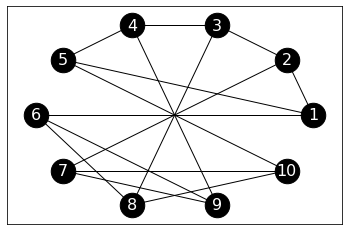

In [5]:
nx.draw_networkx(G_petersen, pos=nx.circular_layout(G_petersen), labels={i: i+1 for i in range(10)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

We have shown previously that the transition matrix is

$$
P = \begin{pmatrix}
0 & 1/3 & 0 & 0 & 1/3 & 1/3 & 0 & 0 & 0 & 0\\
1/3 & 0 & 1/3 & 0 & 0 & 0 & 1/3 & 0 & 0 & 0\\
0 & 1/3 & 0 & 1/3 & 0 & 0 & 0 & 1/3 & 0 & 0\\
0 & 0 & 1/3 & 0 & 1/3 & 0 & 0 & 0 & 1/3 & 0\\
1/3 & 0 & 0 & 1/3 & 0 & 0 & 0 & 0 & 0 & 1/3\\
1/3 & 0 & 0 & 0 & 0 & 0 & 0 & 1/3 & 1/3 & 0\\
0 & 1/3 & 0 & 0 & 0 & 0 & 0 & 0 & 1/3 & 1/3\\
0 & 0 & 1/3 & 0 & 0 & 1/3 & 0 & 0 & 0 & 1/3\\
0 & 0 & 0 & 1/3 & 0 & 1/3 & 1/3 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1/3 & 0 & 1/3 & 1/3 & 0 & 0
\end{pmatrix}
$$

$\lhd$

**EXAMPLE:** **(A Weighted Graph)** Here is another example. Consider the following adjacency matrix on $5$ vertices.

In [6]:
A_ex = np.array([
[0, 8, 0, 1, 0],
[8, 0, 6, 1, 0],
[0, 6, 0, 0, 7],
[1, 1, 0, 0, 10],
[0, 0, 7, 10, 0]
]
)
print(A_ex)

[[ 0  8  0  1  0]
 [ 8  0  6  1  0]
 [ 0  6  0  0  7]
 [ 1  1  0  0 10]
 [ 0  0  7 10  0]]


It is indeed a symmetric matrix.

In [7]:
print(LA.norm(A_ex.T - A_ex))

0.0


We define a graph from its adjacency matrix.

In [8]:
n_ex = A_ex.shape[0] # number of vertices
G_ex = nx.from_numpy_array(A_ex) # graph

To draw it, we first define edge labels by creating a dictionary that assigns to each edge (as a tuple) its weight. Here `G.edges.data('weight')` (see [`G.edges`](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html)) iterates through the edges `(u,v)` and includes their weight as the third entry of the tuple `(u,v,w)`. Then we use the function [`networkx.draw_networkx_edge_labels()`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edge_labels.html#networkx.drawing.nx_pylab.draw_networkx_edge_labels) to add the weights as edge labels.

In [9]:
edge_labels = {}
for (u,v,w) in G_ex.edges.data('weight'):
    edge_labels[(u,v)] = w

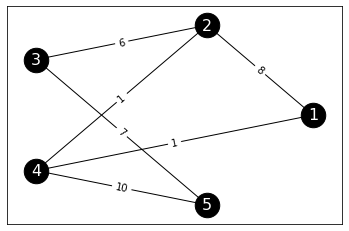

In [10]:
pos=nx.circular_layout(G_ex)
nx.draw_networkx(G_ex, pos, labels={i: i+1 for i in range(n_ex)}, node_size=600, 
                 node_color='black', font_size=16, font_color='white')
edge_labels = nx.draw_networkx_edge_labels(G_ex, pos, edge_labels=edge_labels)

The transition matrix of the random walk on this graph can be computed using the lemma above. We first compute the degree matrix, then apply the formula.

In [11]:
degrees_ex = A_ex @ np.ones(n_ex)
inv_degrees_ex = 1/ degrees_ex
Dinv_ex = np.diag(inv_degrees_ex)
P_ex = Dinv_ex @ A_ex
print(P_ex)

[[0.         0.88888889 0.         0.11111111 0.        ]
 [0.53333333 0.         0.4        0.06666667 0.        ]
 [0.         0.46153846 0.         0.         0.53846154]
 [0.08333333 0.08333333 0.         0.         0.83333333]
 [0.         0.         0.41176471 0.58823529 0.        ]]


This is indeed a stochastic matrix.

In [12]:
print(P_ex @ np.ones(n_ex))

[1. 1. 1. 1. 1.]


$\lhd$

**EXAMPLE:** **(A Weighted Graph, continued)** Going back to our weighted graph example, we use the previous theorem to compute the stationary distribution. Note that the graph is indeed connected so the stationary distribution is unique. We have already computed the degrees.

In [13]:
print(degrees_ex)

[ 9. 15. 13. 12. 17.]


We compute $\sum_{i \in V} \delta(i)$ next.

In [14]:
total_degrees_ex = degrees_ex @ np.ones(n_ex)
print(total_degrees_ex)

66.0


Finally, the stationary distribution is:

In [15]:
pi_ex = degrees_ex / total_degrees_ex
print(pi_ex)

[0.13636364 0.22727273 0.1969697  0.18181818 0.25757576]


We check stationarity.

In [16]:
print(LA.norm(P_ex.T @ pi_ex - pi_ex))

2.7755575615628914e-17


$\lhd$

**NUMERICAL CORNER:** Here is an implementation of the PageRank algorithm. We will need a function that takes as input an adjacency matrix $A$ and returns the corresponding transition matrix $P$. Some vertices have no outgoing links. To avoid dividing by $0$, we add a self-loop to *all vertices with out-degree $0$*. We [`numpy.fill_diagonal`](https://numpy.org/doc/stable/reference/generated/numpy.fill_diagonal.html) for this purpose.

Also, because the adjacency matrix and the vector of out-degrees have different shapes, we turn `out_deg` into a column vector using [`numpy.newaxis`](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis) to ensure that the division is [done one column at a time](https://numpy.org/doc/stable/user/basics.broadcasting.html#broadcastable-arrays). (There are many ways of doing this, [but some are slower than others](https://stackoverflow.com/questions/18522216/multiplying-across-in-a-numpy-array).)

In [17]:
def transition_from_adjacency(A):
    n = A.shape[0]
    sinks = (A @ np.ones(n)) == 0.
    P = A.copy()
    np.fill_diagonal(P, sinks)
    out_deg = P @ np.ones(n)
    P = P / out_deg[:, np.newaxis]
    return P

The following function adds the damping factor. Here `mu` will be the uniform distribution. It gets added (after scaling by `1-alpha`) one row at a time to `P` (again after scaling by `alpha`). This time we do not need to reshape `mu`.

In [18]:
def add_damping(P, alpha, mu):
    Q = alpha * P + (1-alpha) * mu
    return Q

When computing PageRank, we take the transpose of $Q$ to turn multiplication from the left into multiplication from the right.

In [19]:
def pagerank(A, alpha=0.85, max_iter=100):
    n = A.shape[0]
    mu = np.ones(n)/n
    P = transition_from_adjacency(A)
    Q = add_damping(P, alpha, mu)
    v = mu
    for _ in range(max_iter):
        v = Q.T @ v
    return v

Let's try a star with edges pointing out. Along the way, we check that our functions work how we expect them to.

In [20]:
n = 8
G_outstar = nx.DiGraph()
for i in range(1,n):
    G_outstar.add_edge(0,i)

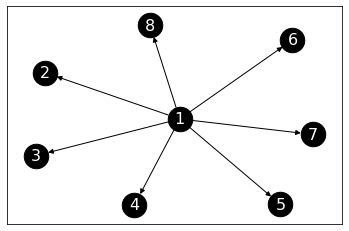

In [21]:
nx.draw_networkx(G_outstar, 
                 labels={i: i+1 for i in range(n)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

In [22]:
A_outstar = nx.adjacency_matrix(G_outstar).toarray()
print(A_outstar)

[[0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [23]:
P_outstar = transition_from_adjacency(A_outstar)
print(P_outstar)

[[0.         0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714 0.14285714]
 [0.         1.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]


In [24]:
alpha = 0.85
mu = np.ones(n)/n
Q_outstar = add_damping(P_outstar, alpha, mu)
print(Q_outstar)

[[0.01875    0.14017857 0.14017857 0.14017857 0.14017857 0.14017857
  0.14017857 0.14017857]
 [0.01875    0.86875    0.01875    0.01875    0.01875    0.01875
  0.01875    0.01875   ]
 [0.01875    0.01875    0.86875    0.01875    0.01875    0.01875
  0.01875    0.01875   ]
 [0.01875    0.01875    0.01875    0.86875    0.01875    0.01875
  0.01875    0.01875   ]
 [0.01875    0.01875    0.01875    0.01875    0.86875    0.01875
  0.01875    0.01875   ]
 [0.01875    0.01875    0.01875    0.01875    0.01875    0.86875
  0.01875    0.01875   ]
 [0.01875    0.01875    0.01875    0.01875    0.01875    0.01875
  0.86875    0.01875   ]
 [0.01875    0.01875    0.01875    0.01875    0.01875    0.01875
  0.01875    0.86875   ]]


While it is tempting to guess that $1$ is the most central node of the network, no edge actually points to it. In this case, the center of the star has a low PageRank value. 

In [25]:
pagerank(A_outstar)

array([0.01875   , 0.14017857, 0.14017857, 0.14017857, 0.14017857,
       0.14017857, 0.14017857, 0.14017857])

We then try a star with edges pointing in.

In [26]:
n = 8
G_instar = nx.DiGraph()
G_instar.add_node(0)
for i in range(1,n):
    G_instar.add_edge(i,0)

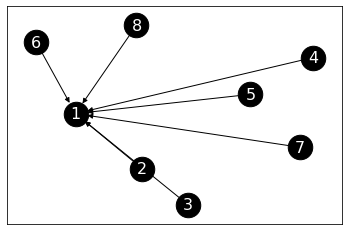

In [27]:
nx.draw_networkx(G_instar,  
                 labels={i: i+1 for i in range(n)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

In [28]:
A_instar = nx.adjacency_matrix(G_instar).toarray()
print(A_instar)

[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]


In [29]:
P_instar = transition_from_adjacency(A_instar)
print(P_instar)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [30]:
Q_instar = add_damping(P_instar, alpha, mu)
print(Q_instar)

[[0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]
 [0.86875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875 0.01875]]


In this case, the center of the star does indeed have a high PageRank value.

In [31]:
pagerank(A_instar)

array([0.86875, 0.01875, 0.01875, 0.01875, 0.01875, 0.01875, 0.01875,
       0.01875])

$\unlhd$

**NUMERICAL CORNER:** We revisit the star example in the undirected case. 

In [32]:
n = 8
G_star = nx.Graph()
for i in range(1,n):
    G_star.add_edge(0,i)

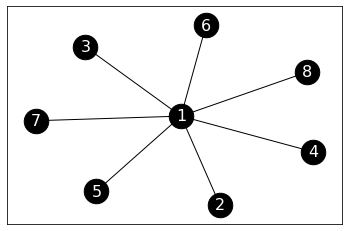

In [33]:
nx.draw_networkx(G_star, 
                 labels={i: i+1 for i in range(n)}, 
                 node_size=600, node_color='black', font_size=16, font_color='white')

We first compute the PageRank vector without damping. Here the random walk is periodic (Why?) so power iteration may fail (Try it!). Instead, we use a small amount of damping and increase the number of iterations.

In [34]:
A_star = nx.adjacency_matrix(G_star).toarray()
print(A_star)

[[0 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]


In [35]:
pagerank(A_star, max_iter=10000, alpha=0.999)

array([0.49979547, 0.07145779, 0.07145779, 0.07145779, 0.07145779,
       0.07145779, 0.07145779, 0.07145779])

The PageRank value for the center node is indeed roughly $7$ times larger than the other ones, as can be expected from the ratio of their degrees. 

We try again with more damping. This time the ratio of PageRank values is not quite the same as the ratio of degrees, but the center node continues to have a higher value than the other nodes. 

In [36]:
pagerank(A_star)

array([0.46959456, 0.07577221, 0.07577221, 0.07577221, 0.07577221,
       0.07577221, 0.07577221, 0.07577221])

$\unlhd$

**Applying PageRank to MathWorld** We load the dataset again.

In [37]:
df_edges = pd.read_csv('mathworld-adjacency.csv')
df_edges.head()

,from,to
0,0,2
1,1,47
2,1,404
3,1,2721
4,2,0


The second file contains the titles of the pages.

In [38]:
df_titles = pd.read_csv('mathworld-titles.csv')
df_titles.head()

,title
0,Alexander's Horned Sphere
1,Exotic Sphere
2,Antoine's Horned Sphere
3,Flat
4,Poincaré Manifold


We construct the graph by adding the edges one by one. We first convert `df_edges` into a Numpy array.

In [39]:
edgelist = df_edges[['from','to']].to_numpy()
print(edgelist)

[[    0     2]
 [    1    47]
 [    1   404]
 ...
 [12361 12306]
 [12361 12310]
 [12361 12360]]


In [40]:
n = 12362
G_mw = nx.empty_graph(n, create_using=nx.DiGraph)
for i in range(edgelist.shape[0]):
    G_mw.add_edge(edgelist[i,0], edgelist[i,1])

To apply PageRank, we construct the adjacency matric of the graph. We also define a vector of title pages.

In [41]:
A_mw = nx.adjacency_matrix(G_mw).toarray()
titles_mw = df_titles['title'].to_numpy()

In [42]:
pr_mw = pagerank(A_mw)

We use [`numpy.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to identify the pages with highest scores. We apply it to `-pr_mw` to sort from the highest to lowest value.

In [43]:
top_pages = np.argsort(-pr_mw)

The top 25 topics are:

In [44]:
titles_mw[top_pages[:25]]

array(['Sphere', 'Circle', 'Prime Number', 'Aleksandrov-Čech Cohomology',
       'Centroid Hexagon', 'Group', 'Fourier Transform', 'Tree',
       'Splitting Field', 'Archimedean Solid', 'Normal Distribution',
       'Integer Sequence Primes', 'Perimeter Polynomial', 'Polygon',
       'Finite Group', 'Large Number', 'Riemann Zeta Function',
       'Chebyshev Approximation Formula', 'Vector', 'Ring',
       'Fibonacci Number', 'Conic Section', 'Fourier Series',
       'Derivative', 'Gamma Function'], dtype=object)

We indeed get a list of central concepts in mathematics -- including several we have encountered previously such as `Normal Distribution`, `Tree`, `Vector` or `Derivative`.

**Personalized PageRank** There is a variant of PageRank, referred to as Personalized PageRank (PPR), which aims to tailor the outcome to specific interests. This is accomplished from a simple change to the algorithm. When teleporting, rather than jumping to a uniformly random page, we instead jump to an arbitrary distribution which is meant to capture some specific interests. In the context of the web for instance, this distribution might be uniform over someone's bookmarks. 

We adapt `pagerank` as follows:

In [45]:
def ppr(A, mu, alpha=0.85, max_iter=100):
    n = A.shape[0]
    P = transition_from_adjacency(A)
    Q = add_damping(P, alpha, mu)
    v = mu
    for _ in range(max_iter):
        v = Q.T @ v
    return v

To test PPR, consider the distribution concentrated on a single topic `Normal Distribution`. This is topic number `1270`.

In [46]:
np.argwhere(titles_mw == 'Normal Distribution')

array([[1270]])

In [47]:
mu = np.zeros(n)
mu[1270] = 1

We now run PPR and list the top 25 pages.

In [48]:
ppr_mw = ppr(A_mw, mu)

In [49]:
top_pers_pages = np.argsort(-ppr_mw)

The top 25 topics are:

In [50]:
titles_mw[top_pers_pages[:25]]

array(['Normal Distribution', 'Pearson System', 'Logit Transformation',
       'z-Score', 'Erf', 'Central Limit Theorem',
       'Bivariate Normal Distribution', 'Normal Ratio Distribution',
       'Normal Sum Distribution', 'Normal Distribution Function',
       'Gaussian Function', 'Standard Normal Distribution',
       'Normal Product Distribution', 'Binomial Distribution',
       'Tetrachoric Function', 'Ratio Distribution',
       'Kolmogorov-Smirnov Test', 'Box-Muller Transformation',
       'Galton Board', 'Fisher-Behrens Problem', 'Erfc',
       'Normal Difference Distribution', 'Half-Normal Distribution',
       'Inverse Gaussian Distribution', 'Error Function Distribution'],
      dtype=object)

This indeed returns various statistical concepts, particularly related to the normal dsitribution. 